# CV Routine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# Load all necessary packages
import sys

import numpy as np
import pandas as pd

sys.path.append("../")
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.algorithms.inprocessing.fairness_adjuster import FairnessAdjuster
from aif360.algorithms.inprocessing.xgb_adversarial_debiasing import (
    XGBAdversarialDebiasing,
)
from aif360.algorithms.inprocessing.xgb_fairness_adjuster import XGBFairnessAdjuster
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_adult,
    load_preproc_data_compas,
    load_preproc_data_german,
)
from aif360.datasets import (
    AdultDataset,
    BinaryLabelDataset,
    CompasDataset,
    GermanDataset,
)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

tf.disable_eager_execution()

2025-01-17 20:19:45.130885: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 20:19:45.142990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737145185.157046   38148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737145185.161258   38148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 20:19:45.175446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
N_SEEDS = 50
SHOW_CI = False

In [4]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult()

privileged_groups = [{"sex": 1}]
unprivileged_groups = [{"sex": 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

/home/ubuntu/AIF360_dev/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


In [5]:
protected_attribute_name = list(unprivileged_groups[0].keys())[0]

In [6]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

min_max_scaler = MaxAbsScaler()

Prep

In [7]:
dataset_orig.features = min_max_scaler.fit_transform(dataset_orig.features)

CV

In [8]:
def get_metrics(
    dataset_orig_test, dataset_pred_test, unprivileged_groups, privileged_groups
):
    metric_dataset_debiasing_test = BinaryLabelDatasetMetric(
        dataset_orig_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    classified_metric_debiasing_test = ClassificationMetric(
        dataset_orig_test,
        dataset_pred_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics_dict = {
        "Test Set: mean outcomes difference": metric_dataset_debiasing_test.mean_difference(),
        "Test Set: Classification accuracy": classified_metric_debiasing_test.accuracy(),
        "Test Set: Disparate impact": classified_metric_debiasing_test.disparate_impact(),
        "Test Set: Average odds difference": classified_metric_debiasing_test.average_odds_difference(),
    }
    return metrics_dict

In [9]:
from copy import copy, deepcopy

import numpy as np
from sklearn.metrics import accuracy_score  # Replace with desired metric
from sklearn.model_selection import KFold


def cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset,
    seeds=5,
    n_folds=5,
    xgb_kwargs={},
):
    """
    Runs cross-validation with multiple seeds.

    Parameters:
        model: The Scikit-learn model to validate.
        X: Feature matrix.
        y: Target vector.
        seeds: Number of seeds for cross-validation.
        folds: Number of folds for each cross-validation.

    Returns:
        results: Dictionary containing accuracy scores for each seed and fold.
    """
    results = {}
    original_df = dataset.convert_to_dataframe()[0]
    for seed in range(seeds):
        print(f"\nSeed {seed + 1}/{seeds}")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        seed_results = {}
        for to_debias in [True, False]:
            model_kwargs["debias"] = to_debias
            fold_results = []
            for fold, (train_idx, test_idx) in enumerate(kf.split(original_df)):
                # print(f"{seed=} || {fold=}")
                # Splitting data
                dataset_X_train, dataset_X_test = dataset.subset(
                    train_idx
                ), dataset.subset(test_idx)

                # Training model
                Z = dataset_X_train.protected_attributes[
                    :,
                    dataset_X_train.protected_attribute_names.index(
                        protected_attribute_name
                    ),
                ]
                model_kwargs["protected_group_vector"] = Z
                model = model_class(**model_kwargs)
                model.fit(dataset_X_train, **xgb_kwargs)

                # Making predictions
                dataset_preds = model.predict(dataset_X_test)

                # Evaluating model
                metrics = get_metrics(
                    dataset_X_test,
                    dataset_preds,
                    model_kwargs["unprivileged_groups"],
                    model_kwargs["privileged_groups"],
                )
                fold_results.append(metrics)

                # end session
            seed_results[f"{to_debias=}"] = fold_results
        results[f"Seed {seed}"] = seed_results

    return results

Fairness adjuster

In [10]:
model_class = XGBFairnessAdjuster
model_kwargs = {
    "privileged_groups": privileged_groups,
    "unprivileged_groups": unprivileged_groups,
    "adversary_loss_weight": 3.0,
    "seed": 1234,
    "task": "classification",
    "use_target": False,
}


xgb_kwargs = {}
xgb_kwargs = {"n_estimators": 200}

# from HPT
# xgb_kwargs = {'n_estimators': 39,
#  'max_leaves': 10,
#  'min_child_weight': 0.0161445270899228,
#  'learning_rate': 1.0,
#  'subsample': 0.23897200706768115,
#  'colsample_bylevel': 0.402794697364951,
#  'colsample_bytree': 0.2687499489421885,
#  'reg_alpha': 0.003216116408209221,
#  'reg_lambda': 6.9123138735089205}

In [11]:
# temp_kwargs = copy(xgb_kwargs)
# temp_kwargs.update({
#     "n_estimators": 18
# })

In [12]:
results = cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset_orig,
    seeds=N_SEEDS,
    n_folds=10,
    xgb_kwargs=xgb_kwargs,
)


Seed 1/50

Seed 2/50

Seed 3/50

Seed 4/50

Seed 5/50

Seed 6/50

Seed 7/50

Seed 8/50

Seed 9/50

Seed 10/50

Seed 11/50

Seed 12/50

Seed 13/50

Seed 14/50

Seed 15/50

Seed 16/50

Seed 17/50

Seed 18/50

Seed 19/50

Seed 20/50

Seed 21/50

Seed 22/50

Seed 23/50

Seed 24/50

Seed 25/50

Seed 26/50

Seed 27/50

Seed 28/50

Seed 29/50

Seed 30/50

Seed 31/50

Seed 32/50

Seed 33/50

Seed 34/50

Seed 35/50

Seed 36/50

Seed 37/50

Seed 38/50

Seed 39/50

Seed 40/50

Seed 41/50

Seed 42/50

Seed 43/50

Seed 44/50

Seed 45/50

Seed 46/50

Seed 47/50

Seed 48/50

Seed 49/50

Seed 50/50


In [14]:
import pickle

with open("./data/xgb_adjuster_adult_group_cv_results.pickle", "wb") as path:
    pickle.dump(results, path, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
aggs = {}
for seed, res_dict in results.items():
    aggs[seed] = {}
    for to_debias, fold_res_dict in res_dict.items():
        res = pd.DataFrame(fold_res_dict).quantile([0.025, 0.975]).T
        res["means"] = pd.DataFrame(fold_res_dict).mean()

        if SHOW_CI:
            aggs[seed][to_debias] = res.apply(
                lambda x: f"{x.means:.4f} ({x[0.025]:.4f},{x[0.975]:.4f})", axis=1
            )
        else:
            aggs[seed][to_debias] = res.means

reform = {
    (outerKey, innerKey): values
    for outerKey, innerDict in aggs.items()
    for innerKey, values in innerDict.items()
}

adjuster_results = pd.DataFrame(reform).T
adjuster_results

Test Set: mean outcomes difference  \
Seed 0  to_debias=True                            -0.194559   
        to_debias=False                           -0.194559   
Seed 1  to_debias=True                            -0.194413   
        to_debias=False                           -0.194413   
Seed 2  to_debias=True                            -0.194519   
...                                                     ...   
Seed 47 to_debias=False                           -0.194537   
Seed 48 to_debias=True                            -0.194535   
        to_debias=False                           -0.194535   
Seed 49 to_debias=True                            -0.194568   
        to_debias=False                           -0.194568   

                         Test Set: Classification accuracy  \
Seed 0  to_debias=True                            0.782851   
        to_debias=False                           0.803366   
Seed 1  to_debias=True                            0.782667   
        to_debias=False                           0.803571   
Seed 2  to_debias=True                            0.782871   
...                                                    ...   
Seed 47 to_debias=False                           0.803530   
Seed 48 to_debias=True                            0.783117   
        to_debias=False                           0.804103   
Seed 49 to_debias=True                            0.782687   
        to_debias=False                           0.803366   

                         Test Set: Disparate impact  \
Seed 0  to_debias=True                     0.957814   
        to_debias=False                    0.000000   
Seed 1  to_debias=True                     0.927303   
        to_debias=False                    0.000000   
Seed 2  to_debias=True                     0.960495   
...                                             ...   
Seed 47 to_debias=False                    0.000000   
Seed 48 to_debias=True                     0.946767   
        to_debias=False                    0.000000   
Seed 49 to_debias=True                     0.949839   
        to_debias=False                    0.000000   

                         Test Set: Average odds difference  
Seed 0  to_debias=True                            0.073820  
        to_debias=False                          -0.289047  
Seed 1  to_debias=True                            0.062954  
        to_debias=False                          -0.289441  
Seed 2  to_debias=True                            0.074244  
...                                                    ...  
Seed 47 to_debias=False                          -0.286507  
Seed 48 to_debias=True                            0.071318  
        to_debias=False                          -0.284646  
Seed 49 to_debias=True                            0.070829  
        to_debias=False                          -0.288509  

[100 rows x 4 columns]

AD

In [18]:
from aif360.algorithms.inprocessing.xgb_adversarial_debiasing import (
    XGBAdversarialDebiasing,
)

model_class = XGBAdversarialDebiasing
model_kwargs = {
    "privileged_groups": privileged_groups,
    "unprivileged_groups": unprivileged_groups,
    "adversary_loss_weight": 3.0,
    "seed": 1234,
    "n_estimators": 20,
}

In [19]:
results = cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset_orig,
    seeds=N_SEEDS,
    n_folds=10,
    xgb_kwargs=xgb_kwargs,
)


Seed 1/50

Seed 2/50

Seed 3/50

Seed 4/50

Seed 5/50

Seed 6/50

Seed 7/50

Seed 8/50

Seed 9/50

Seed 10/50

Seed 11/50

Seed 12/50

Seed 13/50

Seed 14/50

Seed 15/50

Seed 16/50

Seed 17/50

Seed 18/50

Seed 19/50

Seed 20/50

Seed 21/50

Seed 22/50

Seed 23/50

Seed 24/50

Seed 25/50

Seed 26/50

Seed 27/50

Seed 28/50

Seed 29/50

Seed 30/50

Seed 31/50

Seed 32/50

Seed 33/50

Seed 34/50

Seed 35/50

Seed 36/50

Seed 37/50

Seed 38/50

Seed 39/50

Seed 40/50

Seed 41/50

Seed 42/50

Seed 43/50

Seed 44/50

Seed 45/50

Seed 46/50

Seed 47/50

Seed 48/50

Seed 49/50

Seed 50/50


In [20]:
with open("./data/xgb_ad_adult_group_cv_results.pickle", "wb") as path:
    pickle.dump(results, path, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
aggs = {}
for seed, res_dict in results.items():
    aggs[seed] = {}
    for to_debias, fold_res_dict in res_dict.items():
        res = pd.DataFrame(fold_res_dict).quantile([0.025, 0.975]).T
        res["means"] = pd.DataFrame(fold_res_dict).mean()

        if SHOW_CI:
            aggs[seed][to_debias] = res.apply(
                lambda x: f"{x.means:.4f} ({x[0.025]:.4f},{x[0.975]:.4f})", axis=1
            )
        else:
            aggs[seed][to_debias] = res.means

reform = {
    (outerKey, innerKey): values
    for outerKey, innerDict in aggs.items()
    for innerKey, values in innerDict.items()
}

ad_results = pd.DataFrame(reform).T
ad_results.head()

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.194559   
       to_debias=False                           -0.194559   
Seed 1 to_debias=True                            -0.194413   
       to_debias=False                           -0.194413   
Seed 2 to_debias=True                            -0.194519   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                            0.783117   
       to_debias=False                           0.803366   
Seed 1 to_debias=True                            0.782749   
       to_debias=False                           0.803571   
Seed 2 to_debias=True                            0.782953   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     0.952511   
       to_debias=False                    0.000000   
Seed 1 to_debias=True                     0.924993   
       to_debias=False                    0.000000   
Seed 2 to_debias=True                     0.957781   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                            0.072847  
       to_debias=False                          -0.289047  
Seed 1 to_debias=True                            0.062755  
       to_debias=False                          -0.289441  
Seed 2 to_debias=True                            0.073958

In [22]:
adjuster_results.head()

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.194559   
       to_debias=False                           -0.194559   
Seed 1 to_debias=True                            -0.194413   
       to_debias=False                           -0.194413   
Seed 2 to_debias=True                            -0.194519   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                            0.782851   
       to_debias=False                           0.803366   
Seed 1 to_debias=True                            0.782667   
       to_debias=False                           0.803571   
Seed 2 to_debias=True                            0.782871   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     0.957814   
       to_debias=False                    0.000000   
Seed 1 to_debias=True                     0.927303   
       to_debias=False                    0.000000   
Seed 2 to_debias=True                     0.960495   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                            0.073820  
       to_debias=False                          -0.289047  
Seed 1 to_debias=True                            0.062954  
       to_debias=False                          -0.289441  
Seed 2 to_debias=True                            0.074244

In [23]:
import seaborn as sns

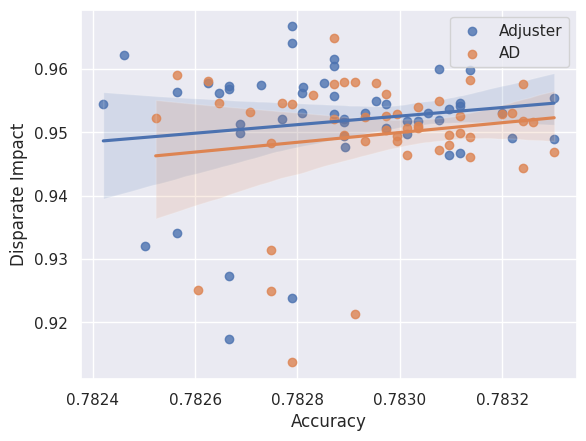

Test Set: mean outcomes difference    0.000000
Test Set: Classification accuracy    -0.010303
Test Set: Disparate impact            0.220595
Test Set: Average odds difference     0.386576
dtype: float64

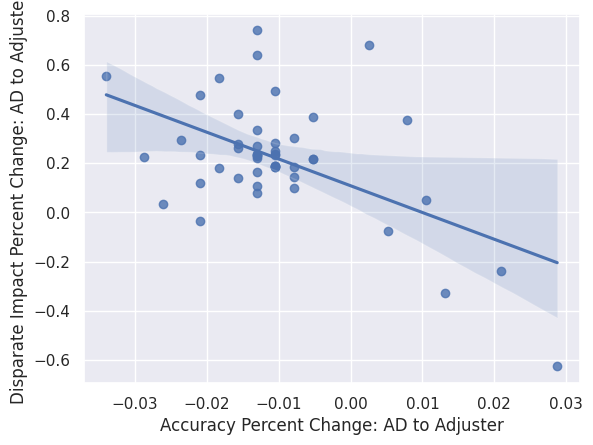

In [24]:
sns.set()
if not SHOW_CI:
    adjuster_results = adjuster_results.loc[
        adjuster_results.index.get_level_values(1) == "to_debias=True"
    ]
    ad_results = ad_results.loc[
        ad_results.index.get_level_values(1) == "to_debias=True"
    ]

    sns.regplot(
        x=adjuster_results["Test Set: Classification accuracy"],
        y=adjuster_results["Test Set: Disparate impact"],
        label="Adjuster",
    )
    sns.regplot(
        x=ad_results["Test Set: Classification accuracy"],
        y=ad_results["Test Set: Disparate impact"],
        label="AD",
    )
    plt.legend()
    plt.xlabel("Accuracy")
    plt.ylabel("Disparate Impact")
    plt.show()

    diffs = (adjuster_results - ad_results) / ad_results * 100
    display(diffs.mean(axis=0))

    sns.regplot(
        x=diffs["Test Set: Classification accuracy"],
        y=diffs["Test Set: Disparate impact"],
    )
    plt.xlabel("Accuracy Percent Change: AD to Adjuster")
    plt.ylabel("Disparate Impact Percent Change: AD to Adjuster")
    plt.show()